In [83]:
import jax
import jax.numpy as jnp
from jax.random import PRNGKey
import matplotlib.pyplot as plt
import relaxed
from functools import partial

# matplotlib settings
plt.rc("figure", figsize=(6, 3), dpi=220, facecolor="w")
plt.rc("legend", fontsize=6)

# generate background data from an exponential distribution
def generate_background(key, n_samples, n_features, noise_std):
    key, subkey = jax.random.split(key, 2)
    data = jax.random.exponential(subkey, (n_samples, n_features))
    key, subkey = jax.random.split(key, 2)
    data += jax.random.normal(subkey, (n_samples, n_features)) * noise_std
    return data


# generate signal data from a normal distribution close to the background
def generate_signal(key, n_samples, n_features):
    key, subkey = jax.random.split(key, 2)
    data = jax.random.normal(subkey, (n_samples, n_features)) / 2 + 2
    return data


# get 1000 samples from the background and 100 samples from the signal
bkg = generate_background(PRNGKey(0), 1000, 1, 0.1).ravel()
sig = generate_signal(PRNGKey(1), 100, 1).ravel()

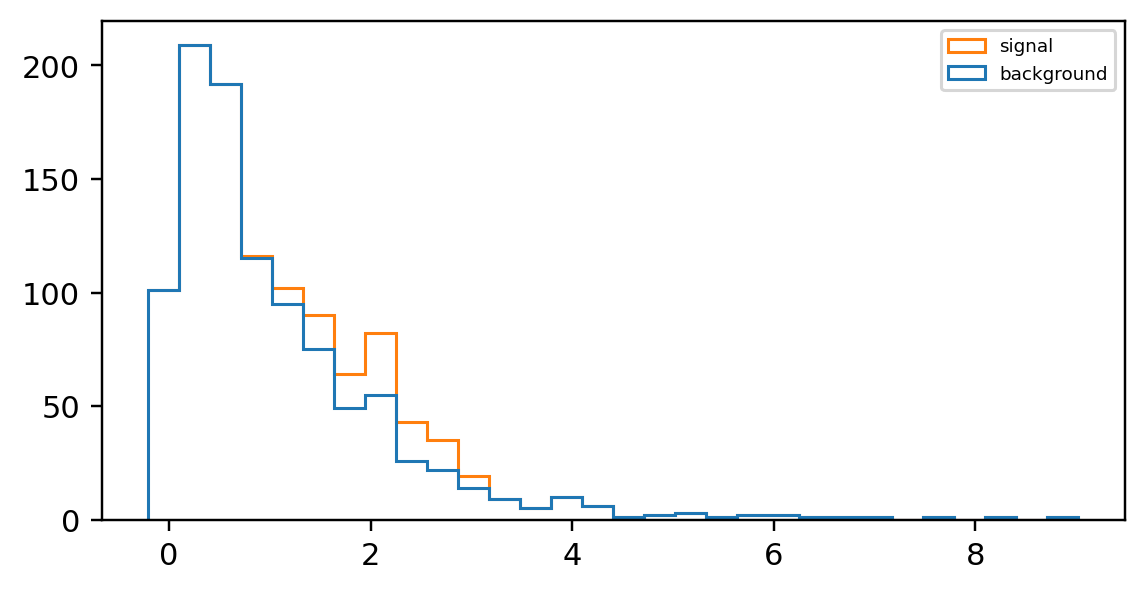

In [84]:
plt.hist(
    [bkg, sig], stacked=True, bins=30, histtype="step", label=["background", "signal"]
)
plt.legend()

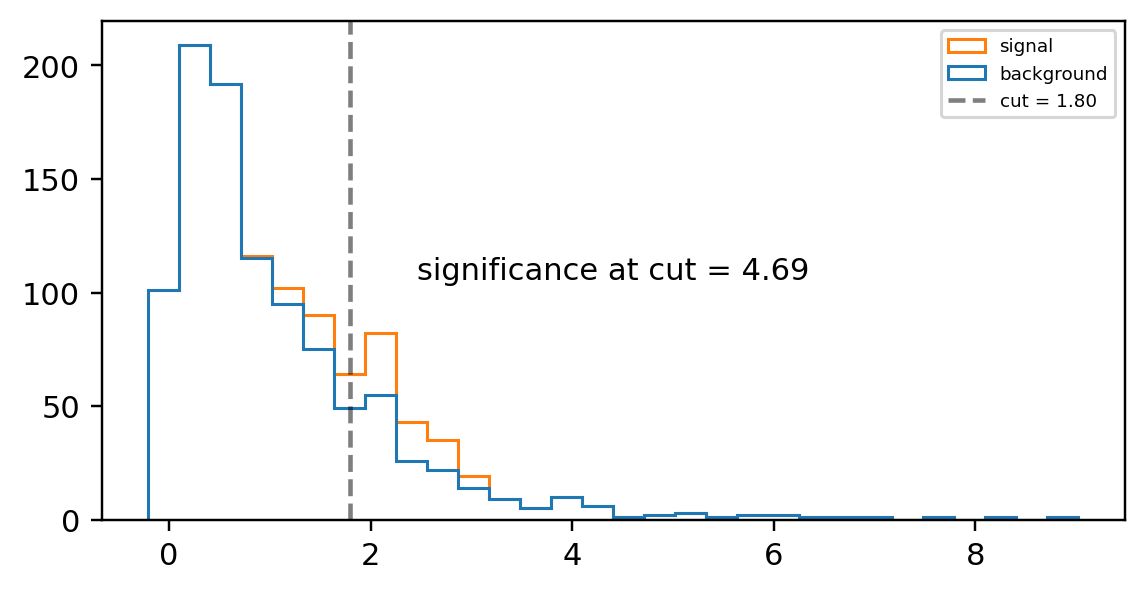

In [113]:
def significance_after_cut(cut):
    s = len(sig[sig > cut])
    b = len(bkg[bkg > cut])
    return relaxed.metrics.asimov_sig(s, b)


cut = 1.8
significance = significance_after_cut(cut)
plt.hist(
    [bkg, sig], stacked=True, bins=30, histtype="step", label=["background", "signal"]
)
plt.axvline(x=cut, color="k", linestyle="--", alpha=0.5, label=f"cut = {cut:.2f}")
plt.text(
    0.5,
    0.5,
    f"significance at cut = {significance:.2f}",
    ha="center",
    va="center",
    transform=plt.gca().transAxes,
)
plt.legend()

Text(0.5, 0.5, 'optimal cut = 1.54')

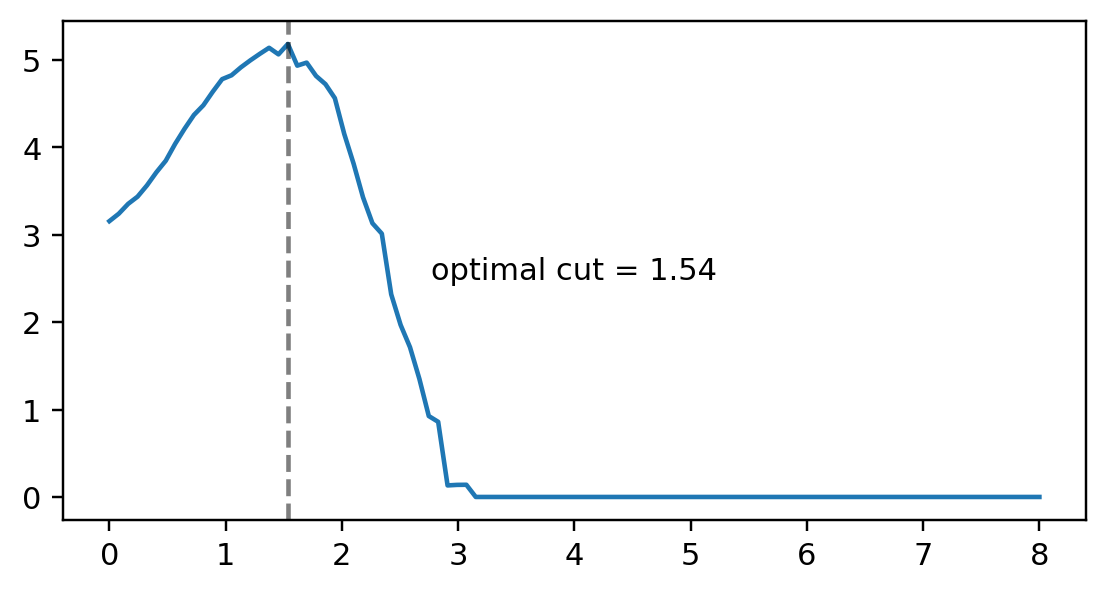

In [90]:
# plot significance for all cut values
cut_values = jnp.linspace(0, 8, 100)
significances_hard = jnp.array([significance_after_cut(cut) for cut in cut_values])
plt.plot(cut_values, significances_hard, label="significance")
optimal_cut = cut_values[jnp.argmax(significances_hard)]
plt.axvline(x=optimal_cut, color="k", linestyle="--", alpha=0.5, label="optimal cut")
plt.text(
    0.5,
    0.5,
    f"optimal cut = {optimal_cut:.2f}",
    ha="center",
    va="center",
    transform=plt.gca().transAxes,
)

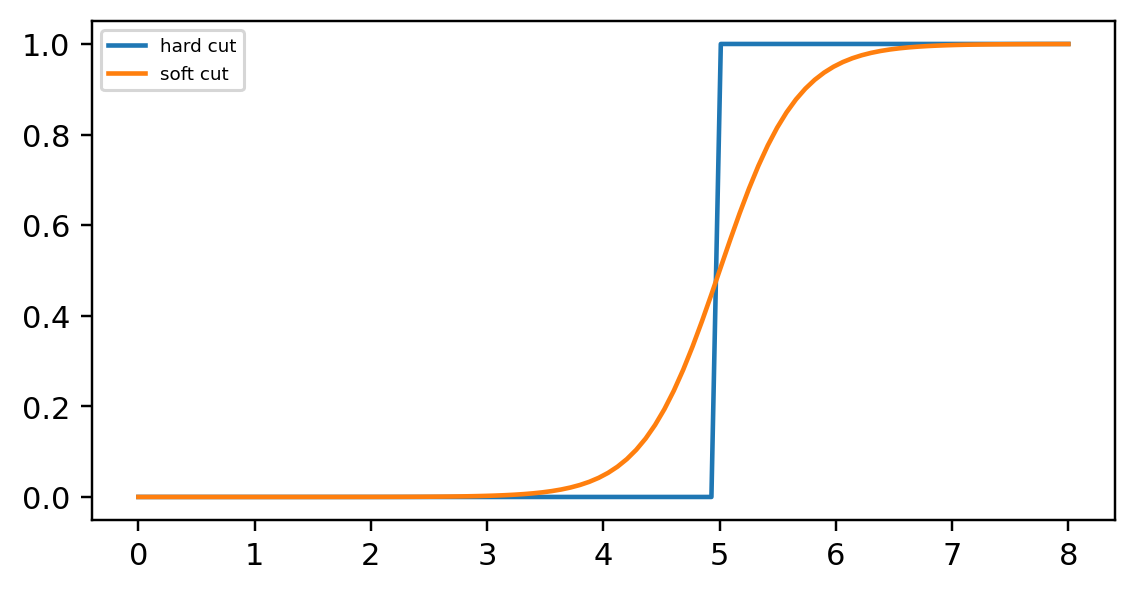

In [100]:
plt.plot(cut_values, cut_values > 5, label="hard cut")
plt.plot(cut_values, relaxed.cut(cut_values, 5, 3), label="soft cut")
plt.legend()

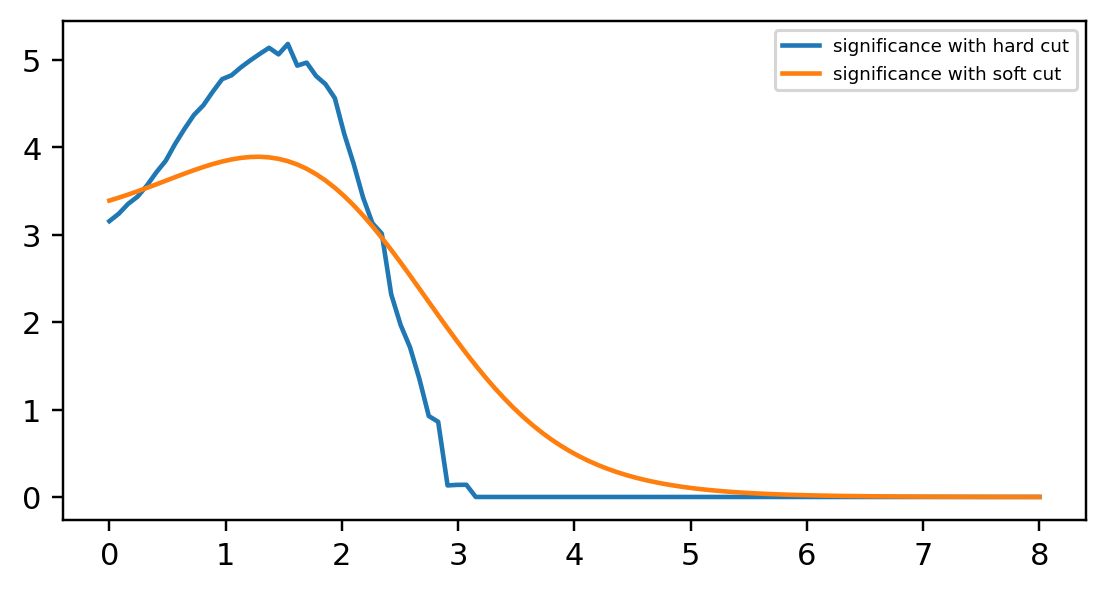

In [94]:
def significance_after_soft_cut(cut, slope):
    s_weights = relaxed.cut(sig, cut, slope)
    b_weights = relaxed.cut(bkg, cut, slope)
    return relaxed.metrics.asimov_sig(s_weights.sum(), b_weights.sum())


# plot significance for all cut values
cut_values = jnp.linspace(0, 8, 100)
soft = partial(significance_after_soft_cut, slope=2)
significances = jax.vmap(soft, in_axes=(0))(cut_values)
plt.plot(cut_values, significances_hard, label="significance with hard cut")
plt.plot(cut_values, significances, label="significance with soft cut")
plt.legend()

In [102]:
from jaxopt import OptaxSolver
from optax import adam


def loss(cut, slope=2):
    s_weights = relaxed.cut(sig, cut, slope)
    b_weights = relaxed.cut(bkg, cut, slope)
    return 1 / relaxed.metrics.asimov_sig(s_weights.sum(), b_weights.sum())


solver = OptaxSolver(loss, adam(learning_rate=1e-2), maxiter=10000, tol=1e-6)
init = 6.0
cut_opt = solver.run(init).params
cut_opt

/Users/phinate/code/relaxed/venv/lib/python3.9/site-packages/jax/_src/tree_util.py:188: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '


DeviceArray(1.2742673, dtype=float32)

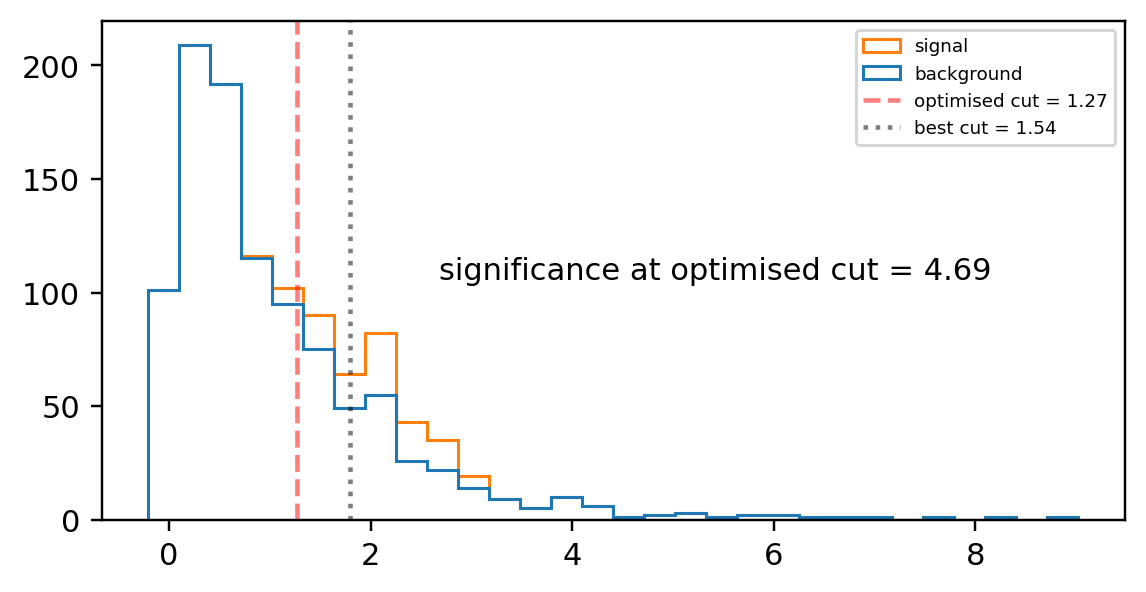

In [115]:
significance = significance_after_cut(cut_opt)
plt.hist(
    [bkg, sig], stacked=True, bins=30, histtype="step", label=["background", "signal"]
)
plt.axvline(
    x=cut_opt,
    color="r",
    linestyle="--",
    alpha=0.5,
    label=f"optimised cut = {cut_opt:.2f}",
)
significance = significance_after_cut(cut)
plt.axvline(
    x=cut, color="k", linestyle=":", alpha=0.5, label=f"best cut = {optimal_cut:.2f}"
)
plt.text(
    0.6,
    0.5,
    f"significance at optimised cut = {significance:.2f}",
    ha="center",
    va="center",
    transform=plt.gca().transAxes,
)
plt.legend()